In [71]:
import numpy as np
import pandas as pd
from scipy import stats
import plotly.express as px
import random 


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
data = pd.read_csv("AdSmartABdata - AdSmartABdata.csv")

In [4]:
data.head(5)

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
0,0008ef63-77a7-448b-bd1e-075f42c55e39,exposed,2020-07-10,8,Generic Smartphone,6,Chrome Mobile,0,0
1,000eabc5-17ce-4137-8efe-44734d914446,exposed,2020-07-07,10,Generic Smartphone,6,Chrome Mobile,0,0
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2020-07-05,2,E5823,6,Chrome Mobile WebView,0,1
3,00187412-2932-4542-a8ef-3633901c98d9,control,2020-07-03,15,Samsung SM-A705FN,6,Facebook,0,0
4,001a7785-d3fe-4e11-a344-c8735acacc2c,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,0


В описании датасета нет информации о том, какое действие пользователя рассматривалось маркетинговой компанией, собирающей данные, в качестве целевого. 

Учитывая, что новая реклама использовалась на этапе предложения пользователю пройти опросник (BIO questionary), можно допустить, что целевое действие - это нажатие кнопки "yes". В таком случае, Conversion Rate (CR) имеет смысл считать как долю нажатий на кнопку "Yes" из общего числа показов рекламы. 

# EDA

Во-первых, в нужных нам колонках не содержится пустых значений

In [13]:
print("Кол-во пропущенных значений в колонке 'experiment': ", len(data[data['experiment'].isna() == True]))
print("Кол-во пропущенных значений в колонке 'yes': ", len(data[data['yes'].isna() == True]))

Кол-во пропущенных значений в колонке 'experiment':  0
Кол-во пропущенных значений в колонке 'yes':  0


Во-вторых, количество пользователей по группам примерно равно: 4071 и 4006 в контрольной и экспериментальной соответственно

In [29]:
fig = px.bar(data.groupby('experiment')['yes'].size().reset_index(), 
             x="experiment", y="yes", color = 'experiment',
             text = 'yes',
             color_discrete_sequence = ['#5F8AD0', '#D05F75'])

fig.update_layout(
    title="Распределение пользователей в группах",
    title_x = 0.5,
    xaxis_title="Группа",
    yaxis_title="Количество пользователей",
    showlegend=False)

fig.show()

В-третьих, CR в exposed выборке выше на 1.21%, чем в контрольной

In [38]:
CR = data.groupby('experiment')['yes'].mean().reset_index()
CR['yes'] = round(CR['yes']*100, 2)

fig = px.bar(CR, 
             x="experiment", y="yes", color = 'experiment',
             text = 'yes',
             color_discrete_sequence = ['#5F8AD0', '#D05F75'])

fig.update_layout(
    title="Конверсия в разных выборках",
    title_x = 0.5,
    xaxis_title="Группа",
    yaxis_title="Конверсия",
    showlegend=False)

fig.show()

Задача теста - определить, насколько разница в показателях для обоих групп статистически значима. Так как мы не ограничены использованием одного теста, попробуем несколько потенциально подходящи вариантов и сравним результаты.

### Нулевая гипотеза: разницы в конверсиях между двумя видами рекламы нет
### Альтернативная гипотеза: разница в конверсиях между двумя видами реклами есть

В качестве уровня значимости традиционно примем 5%

# 1. Тест перестановок
Почему? Тест перестановок - универсальный тест, удобно считающийся при наличии технических ресурсов

In [53]:
def perm_fun(x, nA, nB):
    n = nA + nB
    idx_B = set(random.sample(range(n), nB))
    idx_A = set(range(n)) - idx_B
    return x.loc[idx_B].mean() - x.loc[idx_A].mean()

In [76]:
random.seed(10)
perm_diffs = [perm_fun(data.yes, 
                       4071, 
                       4005) for _ in range(1000)]

Text(0.5, 1.0, 'Разница в конверсии между двумя группами\n(черная линия - налюдаемое значение)\n')

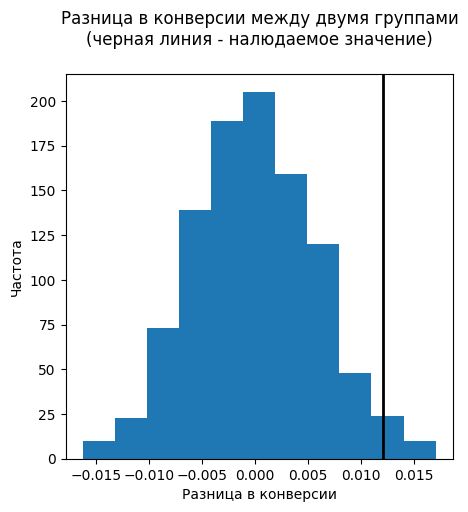

In [77]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(5, 5))
ax.hist(perm_diffs, bins=11)
ax.axvline(x = 0.0121, color='black', lw=2)
ax.set_xlabel('Разница в конверсии')
ax.set_ylabel('Частота')
ax.set_title('Разница в конверсии между двумя группами\n(черная линия - налюдаемое значение)\n')

Больше наблюдаемой разницы (0.0121) случайная величина оказывается в следующей доли случаев:

In [78]:
len([i for i in perm_diffs if i > 0.0121])/len(perm_diffs)

0.023

Другими словами, p-value меньше, чем 0.05, а следовательно мы отвергаем нулевую гипотезу, наблюдаемая нами разница статистически значима

# 2. Z-test
Почему? z-test и t-test широко распространены в индустрии, в нашем случае первый вариант более подходящий, учитывая большой объем выборки

In [79]:
from statsmodels.stats.weightstats import ztest as ztest

control = data[data['experiment']=='control'].yes
exposed = data[data['experiment']=='exposed'].yes

ztest(control, exposed, value=0) 

(-2.108610239127817, 0.03497823834674959)

p-value, согласно z-test, ниже, чем 0.05, а значит мы также можем отвергнуть нулевую гипотезу - разница между конверсиями в двух группах статистически значима

# 3. Хи-квадрат
Почему? Хи-квадрат практически не имеет требований к распределению данных, его можно использовать в качестве дополнительной проверки

In [97]:
t = pd.crosstab(data.experiment, data.yes, normalize="index")
t

yes,0,1
experiment,,
control,0.935151,0.064849
exposed,0.923115,0.076885


In [98]:
stats.chi2_contingency(t) 

Chi2ContingencyResult(statistic=0.0, pvalue=1.0, dof=1, expected_freq=array([[0.9291332, 0.0708668],
       [0.9291332, 0.0708668]]))

В случае хи-квадрата, p-value оказался выше 0.05 - следовательно, можно было бы заявить, что мы не имеем оснований отклонить нулевую гипотезу. 

# Вывод

2/3 тестов показали статистически значимое различие в конверсиях. Только с помощью хи-квадрата не удалось найти разницу, однако стоит учитывать, что критерий Пирсона может плохо работать на неравномерно распределенной таблице сопряжннности (в нашем случае её можно считать таковой). Альтернативой ему мог бы стать точный критерий Фишера, однако он, в свою очередь, не подходит для таких крупных выборок как наша.

Таким образом, имеет смысл доверять предварительно проведенным тестам, - выбор рекламы влияет на конверсию и, судя по EDA, новая реклама положительно сказывается на показателе - однако также стоит проверить эти выводы дополнительно:

1) проведя A/A тест
2) проведя приведенные тесты внутри  подвыборок, соответствующих бы разным девайсам, с которых пользователи видели рекламу (это может быть скрытой переменной, влияющей на эффект)
2) дополнив A/B дополнительными тестами